In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf

In [2]:
##### Limit GPU for training ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# File loading
### read hopital names from datasets ###
df = pd.read_csv(r'../datasets/hospital_augment_train6_6.csv')

In [4]:
df.head()

,gen_data,true_data
0,โรงพยาบาลเมือง-สมุทรปากน้ำ,โรงพยาบาลเมืองสมุทรปากน้ำ
1,โรงพยาบา๋ลบางละมุง,โรงพยาบาลบางละมุง
2,โรงพยาบาลกรุงพทพคริลเตียนนครปฐพ,โรงพยาบาลกรุงเทพคริสเตียนนครปฐม
3,โรงพาบาลบ้านหลวง,โรงพยาบาลบ้านหลวง
4,โรงพยาฌาลโอเวอร์บรู๊ค,โรงพยาบาลโอเวอร์บรู๊ค


In [5]:
df_new = df.sample(frac=1)
#df_new = df_new1.sample(frac=1)

In [6]:
hospital_gen_train = list(df_new['gen_data'])
hospital_true_train = list(df_new['true_data'])

In [7]:
df_test = pd.read_csv(r'../datasets/hospital_augment_test6_4.csv')

In [8]:
hospital_gen_test = list(df_test['gen_data'])
hospital_true_test = list(df_test['true_data'])

In [9]:
from pythainlp import thai_letters

In [10]:
label_map_0 = ["0","1","2","3","4","5","6","7","8","9","-",".","/","(",")","\"","&"]
label_map_1 = list(thai_letters)

In [11]:
char_set = label_map_0+label_map_1

In [12]:
char2int = { char_set[x]:x for x in range(len(char_set)) }
int2char = { char2int[x]:x for x in char_set }

In [13]:
count = len(char_set)
codes = ['\t' ,'\n', ' ']

In [14]:
for i in range(len(codes)):
    code = codes[i]
    char2int[code]=count
    int2char[count]=code
    count+=1

In [15]:
input_texts = []
target_texts = []

In [16]:
hospital_gen_train[:10]

['โรงพยาบาลมหาวชิราลงก๎ณ ธัญบุรี',
 'โรงพยาบาลห้วยผึ้ง',
 'โรงพาบาลเปาโล เกษตร',
 'โรงพยาบาลมหาวชิราลงกรณ ธัญบุรี',
 'โรงพยาบาลเวียงป่าป้า',
 'โรฯยาบาลมะเร็งลำปาง',
 'โรงพฺยาบาลมๅเร็งลพบุรี',
 'โรงพยาบาลเขาสผกิม',
 'โรงพยาบาลสอง',
 'โรงพยาบาลวังสษบูรณ์']

In [17]:
for i,line in enumerate(hospital_true_train):
    output_text = '\t' + line + '\n'
    input_texts.append(hospital_gen_train[i].replace('\u200b',''))
    target_texts.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(input_texts))

LEN OF SAMPLES: 139567


In [18]:
input_texts[0],target_texts[0]

('โรงพยาบาลมหาวชิราลงก๎ณ ธัญบุรี', '\tโรงพยาบาลมหาวชิราลงกรณ ธัญบุรี\n')

In [19]:
max_enc_len = max([len(x)+x.count(' ') for x in input_texts])
max_dec_len = max([len(x)+x.count(' ') for x in target_texts])
print("Max Enc Len:",max_enc_len)
print("Max Dec Len:",max_dec_len)

Max Enc Len: 78
Max Dec Len: 75


In [20]:
idx = int(len(input_texts)*0.1)

In [20]:
num_samples = (len(input_texts))
encoder_input_data = np.zeros( (num_samples , max_enc_len , len(char_set)+3),dtype='float32')
decoder_input_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32')
decoder_target_data = np.zeros( (num_samples , max_dec_len , len(char_set)+3),dtype='float32')
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [21]:
encoder_input_data.shape,decoder_input_data.shape,decoder_target_data.shape

((139567, 78, 93), (139567, 75, 93), (139567, 75, 93))

In [28]:
num_samples_val = idx
encoder_input_data_val = np.zeros( (num_samples_val , max_enc_len , len(char_set)+3),dtype='float32' )
decoder_input_data_val = np.zeros( (num_samples_val , max_dec_len , len(char_set)+3),dtype='float32' )
decoder_target_data_val = np.zeros( (num_samples_val , max_dec_len , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [22]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts,target_texts)):
    for t,char in enumerate(input_text):
        encoder_input_data[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")         

COMPLETED...


In [25]:
val_idx = len(input_texts)-idx

In [24]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(input_texts[:idx],target_texts[:idx])):
    for t,char in enumerate(input_text):
        encoder_input_data_val[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_val[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_val[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")   

COMPLETED...


In [35]:
encoder_input_data.shape,encoder_input_data_val.shape

((85981, 78, 93), (8598, 78, 93))

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense,Activation,Attention,Bidirectional,Concatenate
import tensorflow as tf

In [24]:
batch_size = 128
epochs = 100
latent_dim = 128

num_enc_tokens = len(char_set)+3
num_dec_tokens = len(char_set) + 3 # includes \n \t ' '
encoder_inputs = Input(shape=(None,num_enc_tokens))
encoder = Bidirectional(LSTM(latent_dim,return_state=True))
#encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
#encoder_outputs , state_h, state_c = encoder(encoder_inputs)
#encoder_states = [state_h,state_c]
#encoder_states = [ forward_h, forward_c, backward_h, backward_c]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

In [25]:
decoder_inputs = Input(shape=(None,num_dec_tokens))
decoder_lstm = LSTM(latent_dim*2,return_sequences=True,return_state=True)
#d_outputs, dh1, dc1 = decoder_lstm1(decoder_inputs,initial_state= encoder_states)
#decoder_lstm2 = LSTM(latent_dim*2,return_sequences=True,return_state=True)
decoder_ouputs,_,_ = decoder_lstm(decoder_inputs,initial_state = encoder_states)

In [26]:
num_dec_tokens

93

In [27]:
decoder_dense = Dense(num_dec_tokens, activation='softmax')
decoder_ouputs = decoder_dense(decoder_ouputs)

In [28]:
model = Model([encoder_inputs,decoder_inputs],decoder_ouputs)
#model = Model.add(Attention())
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 256), (None, 227328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]          

In [31]:
model.load_weights('models/bilstm_hosipital_v17')

In [34]:
### Model includes only true sequence ###
earlystop_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0.0001,
  patience=20)

saveModel_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath= "models/bilstm_hosipital_v19",
            save_best_only=True,
            monitor='val_loss',
            save_weights_only = True,
            verbose=1)
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-4 * 0.95 ** x)

In [35]:
import time

In [36]:
start_time = time.time()
hist=model.fit([encoder_input_data,decoder_input_data],decoder_target_data
         ,epochs = 100,validation_split=0.1,
          batch_size = batch_size,callbacks=[earlystop_callback,saveModel_callback])
print("--- %s seconds ---" % (time.time() - start_time))

Train on 125610 samples, validate on 13957 samples
Epoch 1/100
125568/125610 [============================>.] - ETA: 0s - loss: 0.3085
Epoch 00001: val_loss improved from inf to 0.18945, saving model to models/bilstm_hosipital_v19
125610/125610 [==============================] - 50s 399us/sample - loss: 0.3085 - val_loss: 0.1894
Epoch 2/100
125440/125610 [============================>.] - ETA: 0s - loss: 0.1136
Epoch 00002: val_loss improved from 0.18945 to 0.07280, saving model to models/bilstm_hosipital_v19
125610/125610 [==============================] - 45s 360us/sample - loss: 0.1135 - val_loss: 0.0728
Epoch 3/100
125440/125610 [============================>.] - ETA: 0s - loss: 0.0487
Epoch 00003: val_loss improved from 0.07280 to 0.03596, saving model to models/bilstm_hosipital_v19
125610/125610 [==============================] - 44s 351us/sample - loss: 0.0486 - val_loss: 0.0360
Epoch 4/100
125568/125610 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 00004: val_

In [46]:
model.save_weights('models/bilstm_v15')

In [37]:
import matplotlib.pyplot as plt

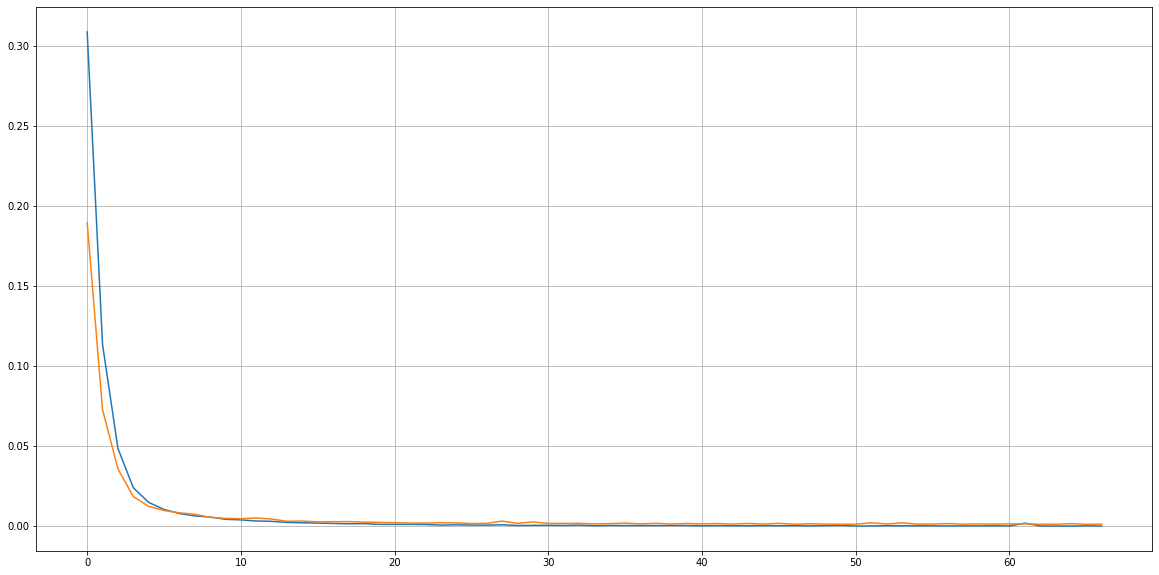

In [38]:
fig= plt.figure(figsize=(20,10)) 
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.grid()

In [107]:
plt.show()

In [38]:
fig.savefig('loss_bilstm_v17.png')

In [39]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_states_inputs = [decoder_state_input_h,decoder_state_input_c]
decoder_outputs,state_h,state_c = decoder_lstm(
        decoder_inputs,initial_state = decoder_states_inputs
)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
encoder_model.save('encoder_v19.h5')
decoder_model.save('decoder_v19.h5')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
encoder_model = load_model('encoder_v8_new.h5',compile=False)

In [ ]:
decoder_model = load_model('decoder_v8_new.h5',compile=False)

In [40]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_dec_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char2int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    decoded_list =[]
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int2char[sampled_token_index]
        decoded_sentence += sampled_char
        decoded_list.append(sampled_char)

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_dec_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence,decoded_list

In [48]:
pred_sent_train = []
for seq_index in range(num_samples):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_train.append(lst)
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', decoded_sentence)
    print('Ground Truth:',target_texts[seq_index])

KeyboardInterrupt: 

In [45]:
test_x = []
test_y = []
for i,line in enumerate(hospital_true_test):
    output_text = '\t' + line + '\n'
    test_x.append(hospital_gen_test[i].replace('\u200b',''))
    test_y.append(output_text.replace('\u200b',''))
print("LEN OF SAMPLES:",len(test_y))

LEN OF SAMPLES: 8500


In [46]:
max_enc_len_test = max([len(x)+x.count(' ') for x in test_x])
max_dec_len_test = max([len(x)+x.count(' ') for x in test_y])
print("Max Enc Len:",max_enc_len_test)
print("Max Dec Len:",max_dec_len_test)

Max Enc Len: 75
Max Dec Len: 75


In [47]:
##### Test Set #####
num_samples_test = len(test_x)
encoder_input_data_test = np.zeros( (num_samples_test , max_enc_len_test , len(char_set)+3),dtype='float32' )
decoder_input_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
decoder_target_data_test = np.zeros( (num_samples_test , max_dec_len_test , len(char_set)+3),dtype='float32' )
print("CREATED ZERO VECTORS")

CREATED ZERO VECTORS


In [48]:
#filling in the enc,dec datas
for i,(input_text,target_text) in enumerate(zip(test_x,test_y)):
    for t,char in enumerate(input_text):
        encoder_input_data_test[ i , t , char2int[char] ] = 1
    for t,char in enumerate(target_text):
        decoder_input_data_test[ i, t , char2int[char] ] = 1
        if t > 0 :
            decoder_target_data_test[ i , t-1 , char2int[char] ] = 1
print("COMPLETED...")  

COMPLETED...


In [49]:
model.evaluate([encoder_input_data_test,decoder_input_data_test],decoder_target_data_test)

8500/8500 [==============================] - 5s 646us/sample - loss: 0.0034


0.0034183083823745085

In [42]:
import time

In [50]:
start_time = time.time()
pred_sent_test = []
for seq_index in range(num_samples_test):
    input_seq = encoder_input_data_test[seq_index: seq_index + 1]
    decoded_sentence,lst = decode_sequence(input_seq)
    pred_sent_test.append(lst)
    sent = str(''.join(lst))
    sent_2 = sent.strip('\n')
    print(seq_index)
    '''
    print('-')
    print('Wrong sentence:', input_texts[seq_index])
    print('Corrected sentence:', sent_2)
    print('Ground Truth:',target_texts[seq_index])
    '''
print("--- %s seconds ---" % (time.time() - start_time))     

4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706


In [ ]:
import pickle
with open('char2int.pickle', 'wb') as handle:
    pickle.dump(char2int, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('int2char.pickle', 'wb') as handle:
    pickle.dump(int2char, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
test_y[0]

'\tคลินิกกรุงเทพพัทยาสาขาจอมเทียน\n'

In [51]:
pred_test = []
for i,key in enumerate(pred_sent_test):
    b = key[:-1]
    sent = ''.join(b)
    pred_test.append(sent)
    print('Input:', test_x[i])
    print('Prediction:', sent)
    print('Ground truth:', test_y[i])

Input: โรงพยาบาลบึงบูร์
Prediction: โรงพยาบาลบึงบูรพ์
Ground truth: 	โรงพยาบาลบึงบูรพ์

Input: โรงพยาบาลยึงสามัคคี
Prediction: โรงพยาบาลท่าสะเกรีย
Ground truth: 	โรงพยาบาลบึงสามัคคี

Input: โรพยาบ้าลบุณฑริก
Prediction: โรงพยาบาลบุณฑริก
Ground truth: 	โรงพยาบาลบุณฑริก

Input: โรงฤยาบาลโุรีรัมย์
Prediction: โรงพยาบาลศรีบุรีรัง
Ground truth: 	โรงพยาบาลบุรีรัมย์

Input: โรงพยาาลเบญซรมย์
Prediction: โรงพยาบาลเบญจรมย์
Ground truth: 	โรงพยาบาลเบญจรมย์

Input: โรงพยาบีลทุมรัตต์
Prediction: โรงพยาบาลปทุมรัตต์
Ground truth: 	โรงพยาบาลปทุมรัตต์

Input: โรงพยาบายลประจวบคีรีขันฤธ์
Prediction: โรงพยาบาลประจวบคีรีขันธ์
Ground truth: 	โรงพยาบาลประจวบคีรีขันธ์

Input: โรงพยาบาลประจักษ์ศ4ิลปาคม
Prediction: โรงพยาบาลประจักษ์ศิลปาคม
Ground truth: 	โรงพยาบาลประจักษ์ศิลปาคม

Input: โรงพยาบาลปรบจันตคาม
Prediction: โรงพยาบาลประจันตคาม
Ground truth: 	โรงพยาบาลประจันตคาม

Input: โรงพยาบา๋ประชาธิปัตย์
Prediction: โรงพยาบาลประชาธิปัตย์
Ground truth: 	โรงพยาบาลประชาธิปัตย์

Input: โรงพยาบาลประฆชาพัฒน์
Prediction: 

In [55]:
pred_test_df = pd.DataFrame(pred_test)

In [56]:
pred_test_df.columns = ['pred_test']

In [57]:
pred_test_df.to_csv('Predict_Test19.csv',index=False)

In [58]:
pred_test_df = pd.read_csv('Output/Predict_Test18.csv')

In [59]:
pred_test= pred_test_df['pred_test']

In [60]:
count =0
wrong_pred =[]
wrong_true =[]
wrong_input = []
for i,key in enumerate(test_y):
    test = key[1:-1]
    if test.replace(' ','') == pred_test[i].replace(' ',''):
        count += 1
    else:
        wrong_pred.append(pred_test[i])
        wrong_true.append(test)
        wrong_input.append(test_x[i])

In [61]:
print('++++++++++ Result of auto-correct-spelling model ++++++++++')
print('Correct sentence:',count)
print('Test sentence:',len(test_y))
print('Missing sentence',len(test_y)-count)
print('Percent of correct sentence',(count/len(test_y)*100),"%")

++++++++++ Result of auto-correct-spelling model ++++++++++
Correct sentence: 8151
Test sentence: 8500
Missing sentence 349
Percent of correct sentence 95.89411764705882 %


In [62]:
#### Incorrect sentence ####
for i,value in enumerate(wrong_input):
    print('Input:', wrong_input[i])
    print('Prediction:', wrong_pred[i])
    print('Gound Thrust:', wrong_true[i])
    print('-')

d Thrust: โรงพยาบาลศรีนคร
-
Input: โรงพยาบ0าลส่งเสริมสุขภาพ ศูนย์อนามัยทฐี่1
Prediction: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่10
Gound Thrust: โรงพยาบาลส่งเสริมสุขภาพ ศูนย์อนามัยที่11
-
Input: โรงพยาบาลสมเำด็จพระบรืราฦินีนาถ ณโอำเภอนาท1วี
Prediction: โรงพยาบาลสมเด็จพระยุพราชเลิงนกิวนทร์
Gound Thrust: โรงพยาบาลสมเด็จพระบรมราชินีนาถ ณ อำเภอนาทวี
-
Input: โรงพยาบาลสมเด็จพระพุทธเลญศหล้า
Prediction: โรงพยาบาลสมเด็จพระยุพราชปัว
Gound Thrust: โรงพยาบาลสมเด็จพระพุทธเลิศหล้า
-
Input: โรงพยาบาลสมเด็จพระยุพราชหล่มษก่า
Prediction: โรงพยาบาลสมเด็จพระยุพราชหล่ม
Gound Thrust: โรงพยาบาลสมเด็จพระยุพราชหล่มเก่า
-
Input: โรงพยาบาลสรแพยา
Prediction: โรงพยาบาลสร้พยา
Gound Thrust: โรงพยาบาลสรรพยา
-
Input: โรงพยาบาลใวี
Prediction: โรงพยาบาลนวี
Gound Thrust: โรงพยาบาลสวี
-
Input: โรงพยาบาลสาีพราน
Prediction: โรงพยาบาลสารคริน
Gound Thrust: โรงพยาบาลสามพราน
-
Input: โรงพยาบาลสารภส
Prediction: โรงพยาบาลสารธิบี
Gound Thrust: โรงพยาบาลสารภี
-
Input: โรงพยาบาลฤุไหงโ)-ลก
Prediction: โรงพยาบาลยุงหลักล้าง
Gound Thrus

In [ ]:
wrong_pred[3],wrong_input[3],wrong_true[3]

In [23]:
df_wrong_input = pd.DataFrame(wrong_input)
df_wrong_pred = pd.DataFrame(wrong_pred)
df_wrong_true = pd.DataFrame(wrong_true)

In [24]:
df_wrong_input.columns=['gen_data']
df_wrong_pred.columns=['pred_data']
df_wrong_true.columns=['true_data']

In [25]:
df_col_merged =pd.concat([df_wrong_input,df_wrong_pred, df_wrong_true],axis=1)

In [26]:
df_col_merged.to_csv('Output/hospital_wrong18.csv',index=False)

In [104]:
from char_error_rate import get_char_error_rate

In [105]:
def createSpace_for_cer(text):
    re = []
    for t in text :
        re.append(t)
        
    #re.append("<eow>")
    #pad_list = ["<pad>"]*(max_seq-len(re)+index)
    #re_pad = re + pad_list
    return re

In [ ]:
pred_test_output = []
for txt in pred_test:
    pred_test_output.append(createSpace_for_cer(txt))

In [ ]:
ground_test =[]
for txt in test_y[:1000]:
    ground_test.append(createSpace_for_cer(txt))

In [ ]:
input_test = []
for txt in test_x[:1000]:
    input_test.append(createSpace_for_cer(txt))

In [ ]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],pred_test_output[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

In [ ]:
cer = 0
for i,key in enumerate(ground_test):
    cer += get_char_error_rate(ground_test[i],input_test[i])
    #print(get_char_error_rate(ground_test[i],pred_test_output[i]))
cer_mean = cer/len(ground_test)  
print('Character Error Rate for Test Set:{}%'.format(cer_mean))

In [ ]:
test_x[50],test_y[50]

In [ ]:
pred_sent_test[50]

In [ ]:
text50 = ''.join(pred_sent_test[50])
text50

In [ ]:
input_seq = encoder_input_data_test[50:51]

In [ ]:
input_seq.shape

In [ ]:
input_seq[0,0,:]

In [ ]:
states_value = encoder_model.predict(input_seq)

In [ ]:
states_value[0].shape

In [ ]:
states_value[1].shape

In [ ]:
target_seq = np.zeros((1, 1, num_dec_tokens))

In [ ]:
target_seq.shape

In [ ]:
target_seq[0, 0, char2int['\t']] = 1

In [ ]:
target_seq

In [ ]:
out = [target_seq]+states_value
len(out)

In [ ]:
output_tokens,h,c = decoder_model.predict([target_seq] + states_value)

In [ ]:
sampled_token_index = np.argmax(output_tokens[0, -1, :])

In [ ]:
np.argmax(output_tokens[0,-1,:])

In [ ]:
stop_condition = False
decoded_sentence = ''
decoded_list =[]
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = int2char[sampled_token_index]
    decoded_sentence += sampled_char
    
    decoded_list.append(sampled_char)
    print('Decoder seq:{}'.format(''.join(decoded_list)))
    print('Character:{}'.format(sampled_char))

    # Exit condition: either hit max length
    # or find stop character.
    if (sampled_char == '\n' or len(decoded_sentence) > max_dec_len):
            stop_condition = True

        # Update the target sequence (of length 1).
    target_seq = np.zeros((1, 1, num_dec_tokens))
    target_seq[0, 0, sampled_token_index] = 1.

        # Update states
    states_value = [h, c]

In [63]:
df_6 = pd.read_csv('../datasets/hospital_augment_train6_3.csv')

In [65]:
df_64 = df_6.sample(frac=1)

In [68]:
dfs = list(df_64['gen_data'])

In [69]:
dfs[-1]

'โรโยาบาลสมเ็จพระยเพราชเดชอุดม'

In [70]:
df_64.to_csv('../datasets/hospital_augment_train6_4.csv',index=False)